In [31]:
# ============================================
# 0. Setup & Imports
# ============================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
# For display
pd.set_option("display.max_columns", 50)

In [32]:
df = pd.read_csv('/content/ethical_ai_bias_llm_dataset.csv')
df

,example_id,model_name,model_version,application_domain,language,region,bias_type,harm_type,protected_group,comparison_group,mitigation_strategy,pre_mitigation_bias_score,post_mitigation_bias_score,toxicity_score,sentiment_score,base_accuracy,post_mitigation_accuracy,performance_drop_fraction,human_fairness_rating_1_5,bias_label,legal_risk_level,is_real_user_case,needs_human_review
0,1,LLM-B,v1,hiring,de,EU,religion,representational,LGBTQ+,elderly,RLHF,0.354,0.248,0.262,0.726,0.935,0.920,0.147,3.00,non_biased,medium,True,False
1,2,LLM-B,v2,lending,en,EU,age,allocative,immigrant,Latinx,adversarial_debiasing,0.313,0.188,0.297,0.959,0.937,0.915,0.224,4.45,non_biased,medium,True,False
2,3,LLM-C,v1,content_moderation,other,SA,other,representational,youth,immigrant,adversarial_debiasing,0.183,0.110,0.204,0.600,0.722,0.703,0.189,3.90,non_biased,low,True,False
3,4,LLM-B,v1,education,zh,NaN,other,allocative,women,refugee,RLHF,0.361,0.253,0.185,0.627,0.932,0.899,0.327,3.30,non_biased,medium,False,False
4,5,LLM-B,v1,healthcare,zh,ME,gender,representational,Black,White,counterfactual_augmentation,0.324,0.227,0.220,0.772,0.807,0.779,0.278,4.58,non_biased,medium,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,LLM-C,v2,healthcare,en,ME,race,representational,immigrant,women,data_balancing,0.208,0.156,0.052,1.000,0.918,0.903,0.157,4.21,non_biased,low,True,False
196,197,LLM-C,v2,healthcare,ar,AS,age,representational,immigrant,low_income,counterfactual_augmentation,0.441,0.309,0.555,0.529,0.806,0.780,0.269,4.37,biased,medium,True,False
197,198,LLM-B,v3,healthcare,hi,EU,culture,both,Asian,high_income,data_balancing,0.240,0.180,0.134,0.770,0.712,0.679,0.330,4.62,non_biased,low,True,False
198,199,LLM-B,v1,customer_support,other,NaN,age,representational,Black,disabled,RLHF,0.464,0.325,0.477,0.471,0.928,0.896,0.322,4.78,biased,medium,True,False


In [33]:
print("Shape:", df.shape)
print(df.head())

# Quick info
print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isna().sum())

# ============================================
# 2. Basic Cleaning / Feature Engineering
# ============================================

# Example: handle missing region as "Unknown"
df["region"] = df["region"].fillna("Unknown")

# Ensure label is categorical
df["bias_label"] = df["bias_label"].astype("category")
df["legal_risk_level"] = df["legal_risk_level"].astype("category")

# Create a numeric binary target for bias_label
df["bias_label_binary"] = (df["bias_label"] == "biased").astype(int)

# Simple composite computational fairness metric (lower = fairer)
# You can refine this for your framework
df["composite_bias_metric"] = (
    df["post_mitigation_bias_score"] * 0.5
    + df["toxicity_score"] * 0.3
    + (1 - df["sentiment_score"]) * 0.2
)

# ============================================
# 3. EDA: Types of Bias and Categories (RQ1)
# ============================================

print("\nBias type distribution:")
print(df["bias_type"].value_counts())

print("\nHarm type distribution:")
print(df["harm_type"].value_counts())

print("\nApplication domain distribution:")
print(df["application_domain"].value_counts())

Shape: (200, 23)
   example_id model_name model_version  application_domain language region  \
0           1      LLM-B            v1              hiring       de     EU   
1           2      LLM-B            v2             lending       en     EU   
2           3      LLM-C            v1  content_moderation    other     SA   
3           4      LLM-B            v1           education       zh    NaN   
4           5      LLM-B            v1          healthcare       zh     ME   

  bias_type         harm_type protected_group comparison_group  \
0  religion  representational          LGBTQ+          elderly   
1       age        allocative       immigrant           Latinx   
2     other  representational           youth        immigrant   
3     other        allocative           women          refugee   
4    gender  representational           Black            White   

           mitigation_strategy  pre_mitigation_bias_score  \
0                         RLHF                      0.35

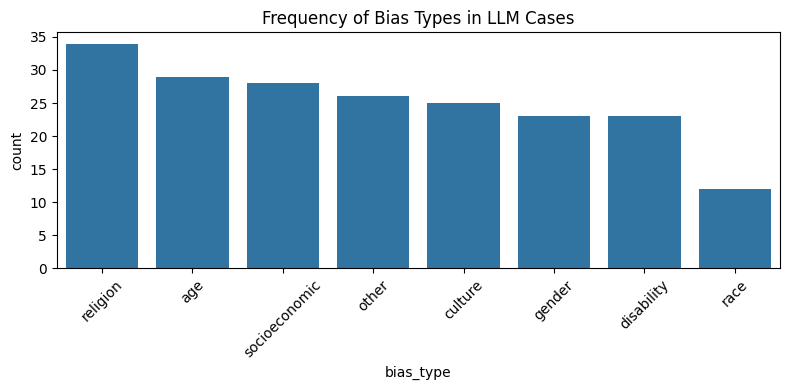

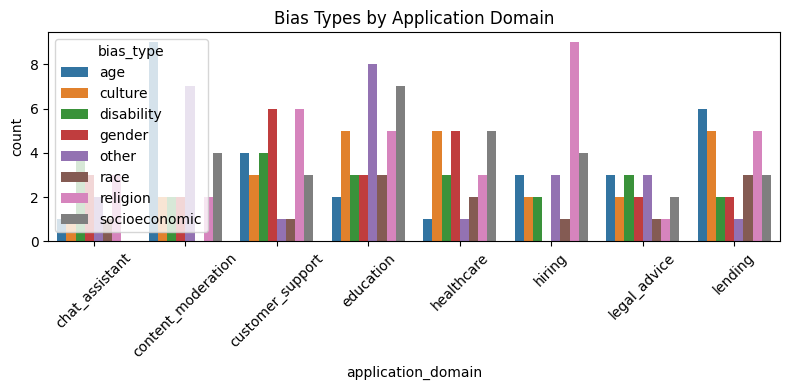

In [34]:
# ---------- Visualization 1: Bias types overall ----------
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="bias_type", order=df["bias_type"].value_counts().index)
plt.title("Frequency of Bias Types in LLM Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ---------- Visualization 2: Bias type by application domain ----------
plt.figure(figsize=(8,4))
bias_domain = (
    df.groupby(["application_domain", "bias_type"])
    .size()
    .reset_index(name="count")
)
sns.barplot(
    data=bias_domain,
    x="application_domain",
    y="count",
    hue="bias_type",
)
plt.title("Bias Types by Application Domain")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


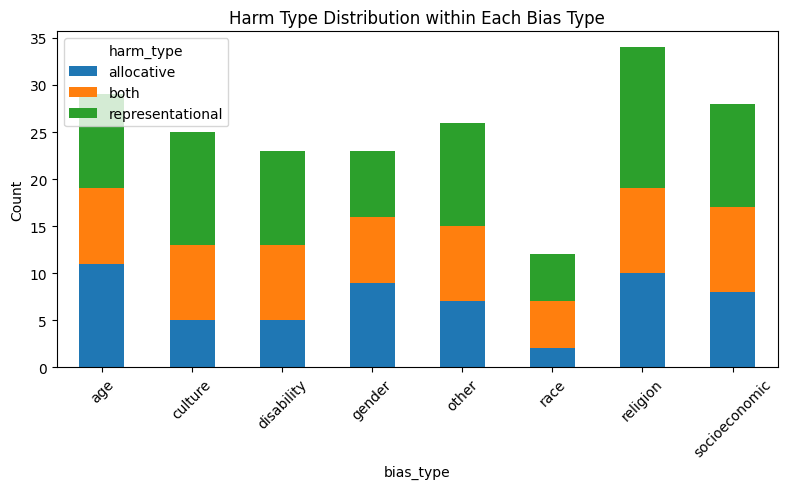


Correlation with human_fairness_rating_1_5:
human_fairness_rating_1_5     1.000000
pre_mitigation_bias_score    -0.663034
post_mitigation_bias_score   -0.702721
toxicity_score               -0.554654
sentiment_score               0.534911
base_accuracy                 0.079640
post_mitigation_accuracy      0.060631
composite_bias_metric        -0.656139
Name: human_fairness_rating_1_5, dtype: float64


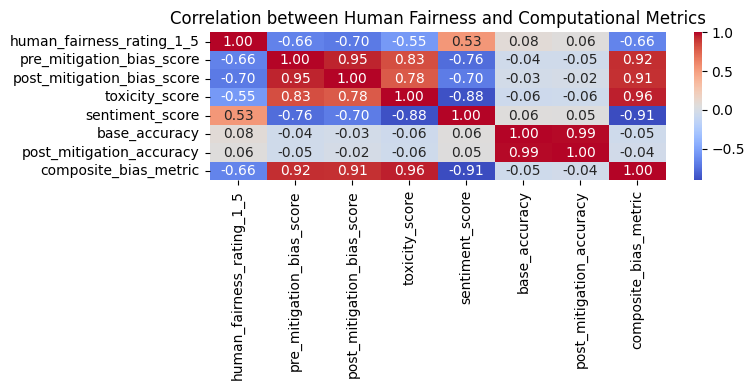

In [35]:
# ---------- Visualization 3: Harm type vs Bias type (stacked style) ----------
harm_bias = (
    df.groupby(["bias_type", "harm_type"])
    .size()
    .reset_index(name="count")
    .pivot(index="bias_type", columns="harm_type", values="count")
    .fillna(0)
)

harm_bias.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Harm Type Distribution within Each Bias Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================
# 4. Integrated Framework: Computational + Human (RQ2)
# ============================================

# Relationship between human fairness rating and computational metrics
print("\nCorrelation with human_fairness_rating_1_5:")
corr_cols = [
    "human_fairness_rating_1_5",
    "pre_mitigation_bias_score",
    "post_mitigation_bias_score",
    "toxicity_score",
    "sentiment_score",
    "base_accuracy",
    "post_mitigation_accuracy",
    "composite_bias_metric",
]
print(df[corr_cols].corr()["human_fairness_rating_1_5"])

# ---------- Visualization 4: Correlation heatmap ----------
plt.figure(figsize=(8,4))
corr_matrix = df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between Human Fairness and Computational Metrics")
plt.tight_layout()
plt.show()

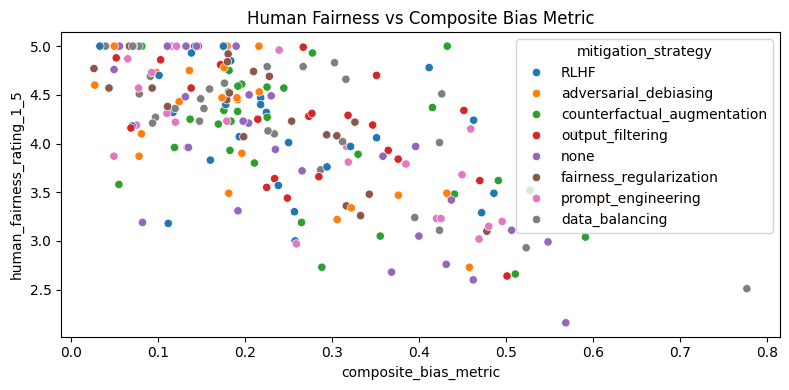


Mitigation strategy summary:
           mitigation_strategy  pre_mitigation_bias_score  \
0                         RLHF                   0.276556   
1        adversarial_debiasing                   0.266091   
2  counterfactual_augmentation                   0.319100   
3               data_balancing                   0.265926   
4      fairness_regularization                   0.285435   
5                         none                   0.275481   
6             output_filtering                   0.323818   
7           prompt_engineering                   0.286773   

   post_mitigation_bias_score  base_accuracy  post_mitigation_accuracy  \
0                    0.193556       0.842889                  0.823111   
1                    0.159682       0.815091                  0.796182   
2                    0.223333       0.801600                  0.781500   
3                    0.199444       0.817222                  0.800889   
4                    0.171087       0.833478      

In [36]:
# Human fairness rating vs composite bias metric
# (lower composite metric should correspond to higher human fairness)
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=df,
    x="composite_bias_metric",
    y="human_fairness_rating_1_5",
    hue="mitigation_strategy",
)
plt.title("Human Fairness vs Composite Bias Metric")
plt.tight_layout()
plt.show()

# ============================================
# 5. Fairness-Performance Trade-offs & Mitigation (RQ3)
# ============================================

group_cols = ["mitigation_strategy"]
agg_metrics = {
    "pre_mitigation_bias_score": "mean",
    "post_mitigation_bias_score": "mean",
    "base_accuracy": "mean",
    "post_mitigation_accuracy": "mean",
    "performance_drop_fraction": "mean",
    "human_fairness_rating_1_5": "mean",
    "composite_bias_metric": "mean",
}
mitigation_summary = df.groupby(group_cols).agg(agg_metrics).reset_index()
print("\nMitigation strategy summary:")
print(mitigation_summary)


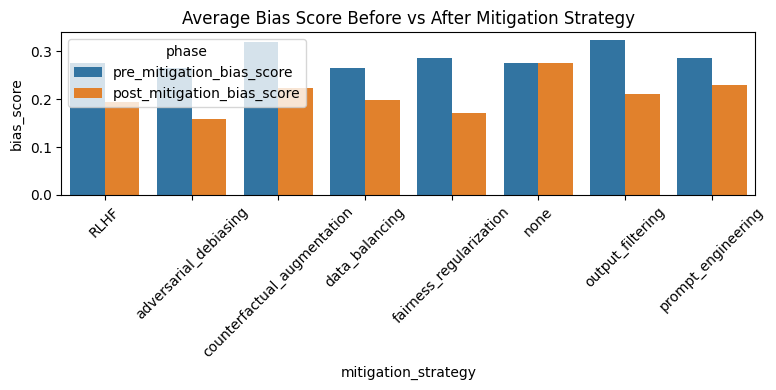

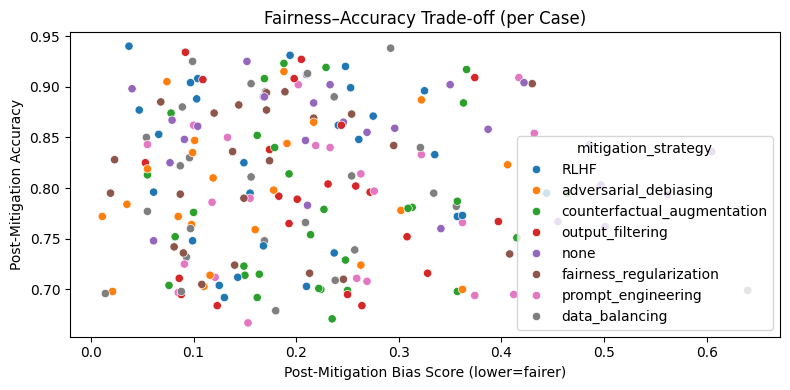

In [37]:
# ---------- Visualization 5: Pre vs Post Bias by Mitigation ----------
plt.figure(figsize=(8,4))
mitigation_summary_melt = mitigation_summary.melt(
    id_vars="mitigation_strategy",
    value_vars=["pre_mitigation_bias_score", "post_mitigation_bias_score"],
    var_name="phase",
    value_name="bias_score",
)
sns.barplot(
    data=mitigation_summary_melt,
    x="mitigation_strategy",
    y="bias_score",
    hue="phase",
)
plt.title("Average Bias Score Before vs After Mitigation Strategy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- Visualization 6: Fairness vs Accuracy Trade-off ----------
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=df,
    x="post_mitigation_bias_score",
    y="post_mitigation_accuracy",
    hue="mitigation_strategy",
)
plt.title("Fairness–Accuracy Trade-off (per Case)")
plt.xlabel("Post-Mitigation Bias Score (lower=fairer)")
plt.ylabel("Post-Mitigation Accuracy")
plt.tight_layout()
plt.show()


Legal risk level distribution:
legal_risk_level
low       113
medium     78
high        9
Name: count, dtype: int64

Average metrics by legal risk level:
                  pre_mitigation_bias_score  post_mitigation_bias_score  \
legal_risk_level                                                          
high                               0.671667                    0.461778   
low                                0.171150                    0.125230   
medium                             0.411859                    0.302205   

                  toxicity_score  composite_bias_metric  \
legal_risk_level                                          
high                    0.623556               0.548511   
low                     0.176035               0.151183   
medium                  0.407051               0.355895   

                  human_fairness_rating_1_5  
legal_risk_level                             
high                               3.072222  
low                                

/tmp/ipython-input-1842999790.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_summary = df.groupby("legal_risk_level")[[


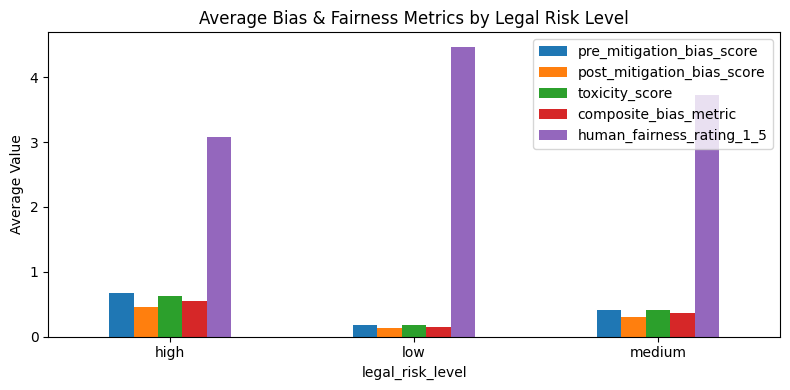

In [38]:
# 6. Ethical, Social & Legal Implications (RQ4)
# ============================================

print("\nLegal risk level distribution:")
print(df["legal_risk_level"].value_counts())

# How legal risk correlates with bias and toxicity
risk_summary = df.groupby("legal_risk_level")[[
    "pre_mitigation_bias_score",
    "post_mitigation_bias_score",
    "toxicity_score",
    "composite_bias_metric",
    "human_fairness_rating_1_5",
]].mean()
print("\nAverage metrics by legal risk level:")
print(risk_summary)

# ---------- Visualization 7: Metrics by legal risk level ----------
risk_summary.plot(kind="bar", figsize=(8,4))
plt.title("Average Bias & Fairness Metrics by Legal Risk Level")
plt.xticks(rotation=0)
plt.ylabel("Average Value")
plt.tight_layout()
plt.show()



Proportion needing human review by domain:
   application_domain  proportion_needing_review
0      chat_assistant                   0.066667
1  content_moderation                   0.142857
2    customer_support                   0.107143
3           education                   0.194444
4          healthcare                   0.280000
5              hiring                   0.083333
6        legal_advice                   0.058824
7             lending                   0.111111


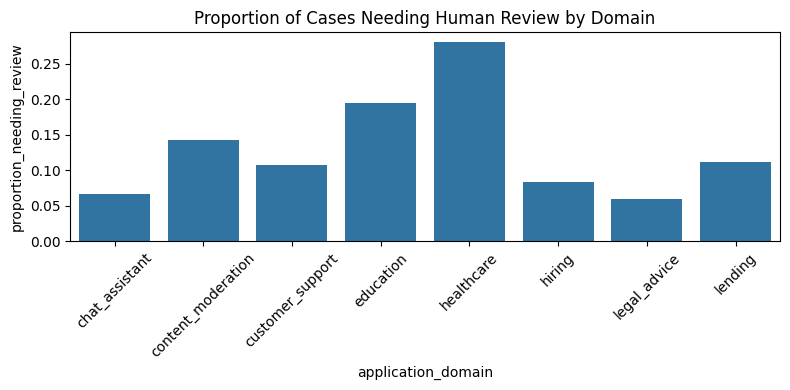

In [39]:
# Counts of cases needing human review, by domain
review_domain = (
    df.groupby("application_domain")["needs_human_review"]
    .mean()
    .reset_index(name="proportion_needing_review")
)
print("\nProportion needing human review by domain:")
print(review_domain)

plt.figure(figsize=(8,4))
sns.barplot(
    data=review_domain,
    x="application_domain",
    y="proportion_needing_review",
)
plt.title("Proportion of Cases Needing Human Review by Domain")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



=== Logistic Regression: Bias Label Prediction ===
              precision    recall  f1-score   support

           0       0.97      0.84      0.90        38
           1       0.65      0.92      0.76        12

    accuracy                           0.86        50
   macro avg       0.81      0.88      0.83        50
weighted avg       0.89      0.86      0.87        50



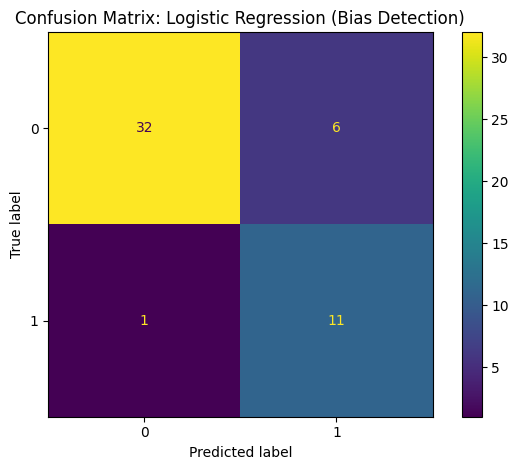


=== Random Forest: Bias Label Prediction ===
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        38
           1       0.73      0.92      0.81        12

    accuracy                           0.90        50
   macro avg       0.85      0.91      0.87        50
weighted avg       0.91      0.90      0.90        50



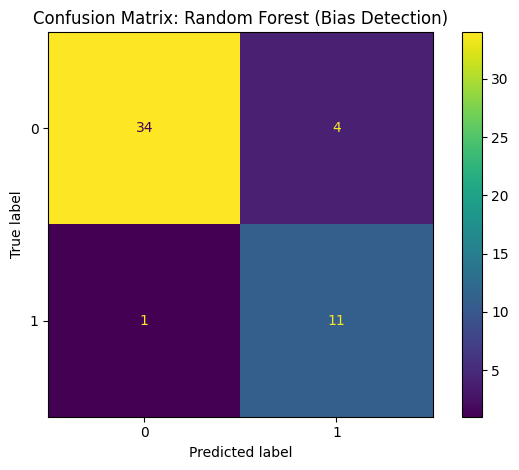

In [40]:
# 7. Model Building: Bias Detection (Classification) (RQ2, RQ3)
# ============================================

# Predict bias_label_binary using context + computational metrics

target_clf = "bias_label_binary"

# Example feature set: contextual + metrics
feature_cols = [
    "model_name",
    "model_version",
    "application_domain",
    "language",
    "region",
    "bias_type",
    "harm_type",
    "mitigation_strategy",
    # numeric:
    "pre_mitigation_bias_score",
    "post_mitigation_bias_score",
    "toxicity_score",
    "sentiment_score",
    "base_accuracy",
    "post_mitigation_accuracy",
    "performance_drop_fraction",
    "human_fairness_rating_1_5",
    "composite_bias_metric",
]

X = df[feature_cols]
y = df[target_clf]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Identify categorical and numeric columns
categorical_cols = [
    "model_name",
    "model_version",
    "application_domain",
    "language",
    "region",
    "bias_type",
    "harm_type",
    "mitigation_strategy",
]
numeric_cols = list(set(feature_cols) - set(categorical_cols))

# Preprocessing
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols),
    ]
)

# Model 1: Logistic Regression
log_reg_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)

log_reg_clf.fit(X_train, y_train)
y_pred_lr = log_reg_clf.predict(X_test)

print("\n=== Logistic Regression: Bias Label Prediction ===")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.title("Confusion Matrix: Logistic Regression (Bias Detection)")
plt.tight_layout()
plt.show()

# Model 2: Random Forest (sometimes better for non-linear relationships)
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42)),
    ]
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("\n=== Random Forest: Bias Label Prediction ===")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix: Random Forest (Bias Detection)")
plt.tight_layout()
plt.show()



=== SVM (RBF): Bias Label Prediction ===
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        38
           1       0.62      0.83      0.71        12

    accuracy                           0.84        50
   macro avg       0.78      0.84      0.80        50
weighted avg       0.87      0.84      0.85        50



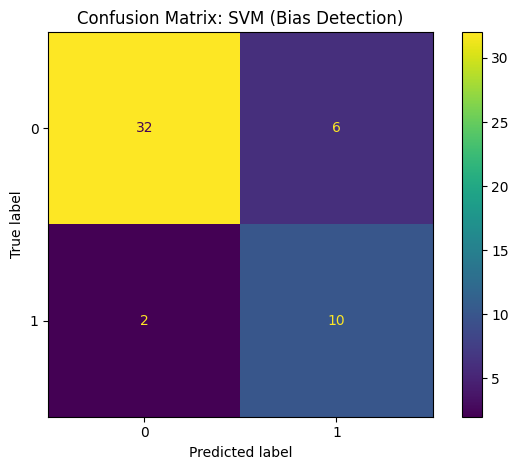

In [41]:
# =========================================================
# Model 3: Support Vector Machine (RBF Kernel)
# =========================================================
svm_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", SVC()),
    ]
)

svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("\n=== SVM (RBF): Bias Label Prediction ===")
print(classification_report(y_test, y_pred_svm))

# OPTIONAL confusion matrix (remove if not needed)
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title("Confusion Matrix: SVM (Bias Detection)")
plt.tight_layout()
plt.show()

In [42]:
# Accuracy and Kappa for all 3 models
# =========================================================

# Logistic Regression
acc_lr = accuracy_score(y_test, y_pred_lr)
kappa_lr = cohen_kappa_score(y_test, y_pred_lr)

# Random Forest
acc_rf = accuracy_score(y_test, y_pred_rf)
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)

# SVM
acc_svm = accuracy_score(y_test, y_pred_svm)
kappa_svm = cohen_kappa_score(y_test, y_pred_svm)

print("\n================== Model Performance Summary ==================")
print(f"Logistic Regression - Accuracy: {acc_lr:.3f}, Kappa: {kappa_lr:.3f}")
print(f"Random Forest       - Accuracy: {acc_rf:.3f}, Kappa: {kappa_rf:.3f}")
print(f"SVM (RBF)           - Accuracy: {acc_svm:.3f}, Kappa: {kappa_svm:.3f}")
print("===============================================================\n")


================== Model Performance Summary ==================
Logistic Regression - Accuracy: 0.860, Kappa: 0.664
Random Forest       - Accuracy: 0.900, Kappa: 0.747
SVM (RBF)           - Accuracy: 0.840, Kappa: 0.606




=== Linear Regression: Human Fairness Rating Prediction ===
MSE: 0.000
R^2: 1.000


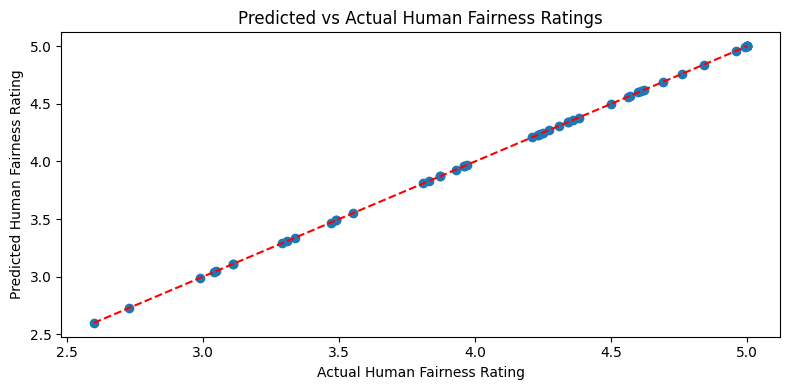

In [43]:
# 8. Model Building: Predicting Human Fairness (Regression)
# ============================================

target_reg = "human_fairness_rating_1_5"

X_reg = df[feature_cols]
y_reg = df[target_reg]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

regressor = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("reg", LinearRegression()),
    ]
)

regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)

mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
print("\n=== Linear Regression: Human Fairness Rating Prediction ===")
print(f"MSE: {mse:.3f}")
print(f"R^2: {r2:.3f}")

# ---------- Visualization 8: Predicted vs Actual Human Fairness ----------
plt.figure(figsize=(8,4))
plt.scatter(y_test_r, y_pred_r)
plt.xlabel("Actual Human Fairness Rating")
plt.ylabel("Predicted Human Fairness Rating")
plt.title("Predicted vs Actual Human Fairness Ratings")
# Add y=x reference line
line_min = min(y_test_r.min(), y_pred_r.min())
line_max = max(y_test_r.max(), y_pred_r.max())
plt.plot([line_min, line_max], [line_min, line_max], "r--")
plt.tight_layout()
plt.show()

In [44]:
# 9. Example: Using the Framework
# ============================================

# This shows how to select "high-risk" cases for human review:
# - high composite bias metric
# - or high legal risk
# - or flagged by model as biased

df["model_predicted_biased_rf"] = rf_clf.predict(X)

high_risk_cases = df[
    (df["legal_risk_level"].isin(["medium", "high"]))
    | (df["composite_bias_metric"] > df["composite_bias_metric"].median())
    | (df["model_predicted_biased_rf"] == 1)
]

print("\nNumber of high-risk cases (for human review):", len(high_risk_cases))
print(high_risk_cases.head())

# Save high-risk subset for manual / qualitative analysis
high_risk_cases.to_csv("high_risk_cases_for_human_review.csv", index=False)
print("\nSaved 'high_risk_cases_for_human_review.csv'")


Number of high-risk cases (for human review): 105
   example_id model_name model_version application_domain language   region  \
0           1      LLM-B            v1             hiring       de       EU   
1           2      LLM-B            v2            lending       en       EU   
3           4      LLM-B            v1          education       zh  Unknown   
4           5      LLM-B            v1         healthcare       zh       ME   
5           6      LLM-B            v2         healthcare    other       EU   

    bias_type         harm_type protected_group comparison_group  \
0    religion  representational          LGBTQ+          elderly   
1         age        allocative       immigrant           Latinx   
3       other        allocative           women          refugee   
4      gender  representational           Black            White   
5  disability  representational          Latinx            women   

           mitigation_strategy  pre_mitigation_bias_score  \
0   